# RLCT Estimation of MNIST

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

## Main Steps:

1. **Data Preparation**: Load the MNIST dataset for training and testing.
2. **Model Training**: Train a multi-layer perceptron model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

sys.path.insert(1, "/home/paperspace/devinterp")  # TODO fix path

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# Define the neural network
class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [3]:
DEVICE = "cuda"
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST(
    "./data", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("./data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 20

60000


In [4]:
# train model
train_losses = []
test_losses = []
rlct_estimates = []
models = []
for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    # rlct_estimates.append(rlct_estimate)
    models += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
torch.save(models, "models.pth")

100%|██████████| 118/118 [00:08<00:00, 14.20it/s]


Epoch 1, Train Loss: 1.4781936240398277, Test Loss: 0.5404277428984642


100%|██████████| 118/118 [00:07<00:00, 14.80it/s]


Epoch 2, Train Loss: 0.4309507560426906, Test Loss: 0.35210140496492387


100%|██████████| 118/118 [00:07<00:00, 14.89it/s]


Epoch 3, Train Loss: 0.33705323606224386, Test Loss: 0.30257405415177346


100%|██████████| 118/118 [00:08<00:00, 14.70it/s]


Epoch 4, Train Loss: 0.2965033372579995, Test Loss: 0.2742203287780285


100%|██████████| 118/118 [00:07<00:00, 14.96it/s]


Epoch 5, Train Loss: 0.2691104213817645, Test Loss: 0.25124075897037984


100%|██████████| 118/118 [00:07<00:00, 15.17it/s]


Epoch 6, Train Loss: 0.246300771201061, Test Loss: 0.23392464593052864


100%|██████████| 118/118 [00:07<00:00, 14.95it/s]


Epoch 7, Train Loss: 0.22579188430208272, Test Loss: 0.21757659427821635


100%|██████████| 118/118 [00:07<00:00, 14.89it/s]


Epoch 8, Train Loss: 0.2084520902421515, Test Loss: 0.2034239735454321


100%|██████████| 118/118 [00:07<00:00, 14.85it/s]


Epoch 9, Train Loss: 0.1940159750944477, Test Loss: 0.18552074544131755


 69%|██████▉   | 82/118 [00:05<00:02, 14.37it/s]

In [ ]:
from devinterp.slt.sampler import estimate_rlct

# Load MNIST data
batch_size = 512
train_data = datasets.MNIST(
    "./data", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("./data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

rlct_estimates_sgnht = []
rlct_estimates_sgdl = []
for n in range(n_epochs):
    rlct_estimate_sgnht = estimate_rlct(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
            batch_size=batch_size,
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=1_000,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
    )
    rlct_estimate_sgdl = estimate_rlct(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.,
            elasticity=100.,
            bounding_box_size=1.0,
            num_samples=len(train_data),
            temperature='adaptive'
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=1_000,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgdl += [rlct_estimate_sgdl]
plt.hist(rlct_estimates_sgnht, alpha=0.5, label="sgnht")
plt.hist(rlct_estimates_sgdl, alpha=0.5, label="sgdl")
plt.legend()
plt.show()
# Plotting

SyntaxError: invalid syntax (2977093611.py, line 40)

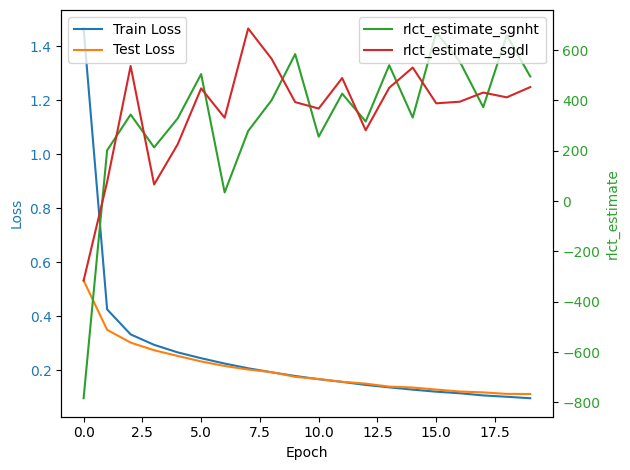

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:blue")
ax1.plot(train_losses, label="Train Loss", color="tab:blue")
ax1.plot(test_losses, label="Test Loss", color="tab:orange")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.set_ylabel("rlct_estimate", color="tab:green")
ax2.plot(rlct_estimates_sgnht, label="rlct_estimate_sgnht", color="tab:green")
ax2.plot(rlct_estimates_sgdl, label="rlct_estimate_sgdl", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:green")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()